In [ ]:
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip

--2023-01-03 01:31:32--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.40.232, 3.5.68.144, 52.218.116.130, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.40.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95592747 (91M) [application/octet-stream]
Saving to: ‘4drtyfjtfy-1.zip’

4drtyfjtfy-1.zip    100%[===================>]  91.16M  21.1MB/s    in 4.3s    

2023-01-03 01:31:37 (21.4 MB/s) - ‘4drtyfjtfy-1.zip’ saved [95592747/95592747]



In [ ]:
!unzip -qq 4drtyfjtfy-1.zip
!unzip -qq dataset2.zip


In [ ]:
import torch
from torch import nn
import numpy as np
import os
import random
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as tr #데이터 증강 image augmentation

In [ ]:
os.makedirs('new_dataset/train', exist_ok=True)
os.makedirs('new_dataset/valid', exist_ok=True)

In [ ]:
#이미지 정리
labels = ['cloudy', 'rain', 'sunrise', 'shine']
for root, dirs, filenames in os.walk('dataset2'):
    for filename in filenames:
        path = os.path.join(root, filename)
        image = cv2.imread(path)
        if image is None:
            print('failed : ', path)
            continue
        if random.random() < 0.9:
            nu_root = 'new_dataset/train'
        else:
            nu_root = 'new_dataset/valid'
        first, last = os.path.splitext(filename)
        new_path = os.path.join(nu_root, first + '.jpg')
        cv2.imwrite(new_path, image)


failed :  dataset2/shine131.jpg
failed :  dataset2/rain141.jpg


In [ ]:
meta_train = []
meta_valid = []

for root, dirs, filenames in os.walk('new_dataset'):
    if 'train' in root:
        meta = meta_train
    elif 'valid' in root:
        meta = meta_valid
    else:
        continue

    for filename in filenames:
        for index, label_name in enumerate(labels):
            if label_name in filename:
                label = index
                break
        else:
            continue

        path = os.path.join(root, filename)
        meta.append((path, label))


In [ ]:
len(meta_train), len(meta_valid)

(1002, 121)

In [ ]:
meta_train[:10]

[('new_dataset/train/sunrise321.jpg', 2),
 ('new_dataset/train/rain185.jpg', 1),
 ('new_dataset/train/sunrise107.jpg', 2),
 ('new_dataset/train/cloudy197.jpg', 0),
 ('new_dataset/train/rain72.jpg', 1),
 ('new_dataset/train/cloudy228.jpg', 0),
 ('new_dataset/train/shine63.jpg', 3),
 ('new_dataset/train/cloudy119.jpg', 0),
 ('new_dataset/train/cloudy37.jpg', 0),
 ('new_dataset/train/sunrise142.jpg', 2)]

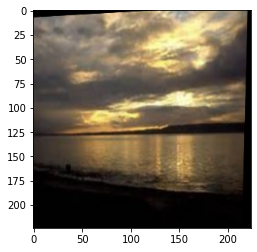

torch.Size([3, 224, 224])


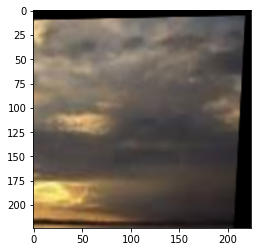

torch.Size([3, 224, 224])


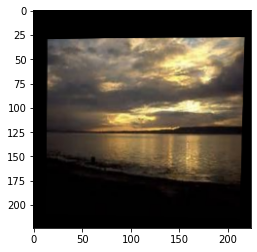

torch.Size([3, 224, 224])


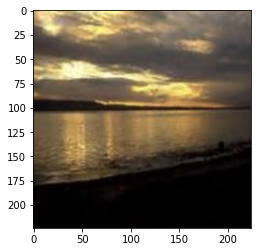

torch.Size([3, 224, 224])


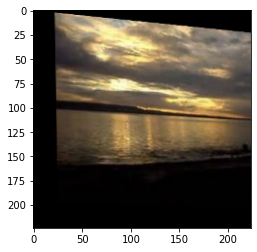

torch.Size([3, 224, 224])


In [ ]:
# https://pytorch.org/vision/stable/transforms.html
# https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
trans_train = tr.Compose([
    tr.Resize((224 + 150, 224 + 150)),
    tr.RandomHorizontalFlip(),
    tr.RandomPerspective(distortion_scale=0.3, p=1.0),
    tr.RandomResizedCrop(size=(224, 224)) # 데이터 증강
])

trans_valid = tr.Compose([
    tr.Resize((224, 224)),
])

test = torchvision.io.read_image('new_dataset/valid/sunrise343.jpg')
for _ in range(5):
    dst = trans_train(test)
    plt.imshow(dst.permute(1, 2, 0))
    plt.show()
    print(dst.shape)

In [ ]:
class WeatherDataset(torch.utils.data.Dataset):
    def __init__(self, path_label, trans):
        self.path_label = path_label
        self.trans = trans
    def __len__(self):
        return len(self.path_label)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        path, label = self.path_label[idx]
        image = torchvision.io.read_image(path) #CHW RGB
        image = self.trans(image).type(torch.float32)
        label = torch.tensor(label, dtype=torch.int64)
        return image, label

dataset_train = WeatherDataset(meta_train, trans_train)
dataset_valid = WeatherDataset(meta_valid, trans_valid)

In [ ]:
# a = [1, 2, 3]
# b = ['a', 'b', 'c']
# c = list(zip(a, b))
# a_, b_ = list(zip(*c))
# b_

('a', 'b', 'c')

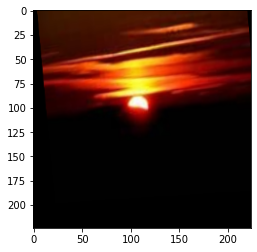

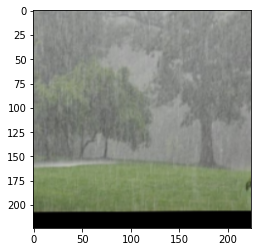

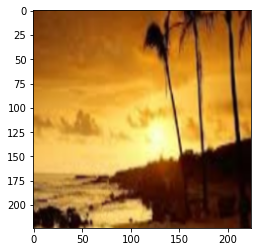

In [ ]:
for i in range(3):
    image, label = dataset_train[i]
    plt.imshow(image.permute(1, 2, 0).type(torch.uint8))
    plt.show()

In [ ]:
batch_size = 32
loader_train = torch.utils.data.DataLoader(dataset_train,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=1)
loader_valid = torch.utils.data.DataLoader(dataset_valid,
                                           batch_size=batch_size,
                                           num_workers=1)

# Model

In [ ]:
import torchvision.models as models
models.list_models()

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [ ]:
regnet = models.regnet_y_400mf(weights='DEFAULT')
regnet.eval()

Downloading: "https://download.pytorch.org/models/regnet_y_400mf-e6988f5f.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_400mf-e6988f5f.pth
100%|██████████| 16.8M/16.8M [00:01<00:00, 17.5MB/s]


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
            

In [ ]:
!wget https://cdn.britannica.com/03/234203-050-C3D47B4B/Shih-tzu-dog.jpg -O test.jpg

--2023-01-03 02:02:56--  https://cdn.britannica.com/03/234203-050-C3D47B4B/Shih-tzu-dog.jpg
Resolving cdn.britannica.com (cdn.britannica.com)... 52.222.139.5, 52.222.139.124, 52.222.139.64, ...
Connecting to cdn.britannica.com (cdn.britannica.com)|52.222.139.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151514 (148K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>] 147.96K  --.-KB/s    in 0.009s  

2023-01-03 02:02:56 (15.4 MB/s) - ‘test.jpg’ saved [151514/151514]



In [ ]:
!wget https://cdn.shopify.com/s/files/1/0531/2475/9744/files/1_1_2.jpg -O test2.jpg

--2023-01-03 02:01:12--  https://cdn.shopify.com/s/files/1/0531/2475/9744/files/1_1_2.jpg
Resolving cdn.shopify.com (cdn.shopify.com)... 185.146.173.22
Connecting to cdn.shopify.com (cdn.shopify.com)|185.146.173.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 442258 (432K) [image/jpeg]
Saving to: ‘test2.jpg’

test2.jpg           100%[===================>] 431.89K  --.-KB/s    in 0.05s   

2023-01-03 02:01:12 (7.96 MB/s) - ‘test2.jpg’ saved [442258/442258]



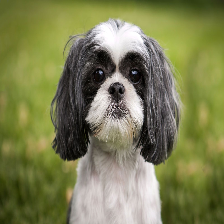

(1, 3, 224, 224)

In [ ]:
image = cv2.imread('test.jpg')
image = cv2.resize(image, (224, 224))
cv2_imshow(image)
image = image[None, ..., ::-1] / 255
image = np.transpose(image, (0, 3, 1, 2))
image.shape

In [ ]:
input = torch.tensor(image.astype(np.float32))
weights = models.RegNet_Y_32GF_Weights.DEFAULT
preprocess = weights.transforms()
input = preprocess(input)
result = regnet.forward(input).detach().numpy()
result.argmax()

155

In [ ]:
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
pretrained = models.regnet_y_400mf(weights='DEFAULT')


In [ ]:
pretrained = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [ ]:
for index, module in enumerate(pretrained.children()):
    print(index, '======================')
    print(module)

In [ ]:
from torchsummary import summary
summary(pretrained, (3, 224, 224), device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4           [-1, 48, 56, 56]           1,536
       BatchNorm2d-5           [-1, 48, 56, 56]              96
            Conv2d-6         [-1, 48, 112, 112]           1,536
       BatchNorm2d-7         [-1, 48, 112, 112]              96
              ReLU-8         [-1, 48, 112, 112]               0
            Conv2d-9           [-1, 48, 56, 56]           3,456
      BatchNorm2d-10           [-1, 48, 56, 56]              96
             ReLU-11           [-1, 48, 56, 56]               0
AdaptiveAvgPool2d-12             [-1, 48, 1, 1]               0
           Conv2d-13              [-1, 8, 1, 1]             392
             ReLU-14              [-1, 

In [ ]:
backbone_modules = list(pretrained.children())[:3]
backbone = torch.nn.Sequential(*backbone_modules)

In [ ]:
backbone(torch.zeros(1, 3, 224, 224)).shape

torch.Size([1, 440, 1, 1])

In [ ]:
z = backbone(torch.zeros(1, 3, 224, 224))
z = nn.Flatten()(z)
z = nn.Linear(440, len(labels))(z)
z.shape

class MyModel(nn.Module):
    def __init__(self, backbone, label_num = 4, **kwargs):
        super().__init__(**kwargs)
        self.backbone = backbone
        self.linear = nn.Linear(1280, label_num)
        self.trans = tr.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def forward(self, input):
        z = self.trans(input)
        z = self.backbone(z)
        z = nn.Flatten()(z)
        z = self.linear(z)
        return z
model = MyModel(backbone, len(labels))

In [ ]:
class MobileNetPreProcess(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.trans = tr.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    def forward(self, input):
        return self.trans(input)

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
# for param in backbone.parameters():
#     param.requires_grad = False

In [ ]:
head = nn.Linear(1280, len(labels))
model = nn.Sequential(
    tr.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    backbone,
    nn.AvgPool2d(7),
    nn.Flatten(),
    head
).to(device)

opt = torch.optim.AdamW(head.parameters())
backbone.requires_grad_(False)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
for epoch in range(5):
    model.train()
    for step, (x, y) in enumerate(loader_train):
        logits = model(x.to(device))
        loss = loss_fn(logits, y.to(device))
        opt.zero_grad()
        loss.backward()
        opt.step()
        #acc
        pred = torch.argmax(logits.to('cpu'), axis=1)
        acc = sum(pred == y) / batch_size
        print(f'\r[{epoch}] {step} loss={loss.item()}  acc={acc.item()}', end='')
    model.eval()
    with torch.no_grad():
        val_loss = []
        val_acc = []
        for step, (x, y) in enumerate(loader_valid):
            logits = model(x.to(device)).to('cpu')
            loss = loss_fn(logits, y)
            #acc
            pred = torch.argmax(logits, axis=1)
            acc = sum(pred == y) / batch_size
            val_loss.append(loss.item())
            val_acc.append(acc.item())
        val_loss = np.mean(val_loss)
        val_acc = np.mean(val_acc)
        print(f'  val_loss={val_loss}  val_acc={val_acc}', end='')
    print()

[0] 31 loss=0.7880065441131592  acc=0.0625  val_loss=1.484720841050148  val_acc=0.8359375
[1] 31 loss=1.3176237344741821  acc=0.0625  val_loss=0.20921750366687775  val_acc=0.953125
[2] 31 loss=0.015589079819619656  acc=0.09375  val_loss=0.15078824013471603  val_acc=0.9375
[3] 31 loss=0.8781865239143372  acc=0.0625  val_loss=0.10114683583378792  val_acc=0.9765625
[4] 31 loss=0.03527935594320297  acc=0.09375  val_loss=0.11356230545789003  val_acc=0.9609375


In [ ]:
opt = torch.optim.AdamW(model.parameters())
backbone.requires_grad_(True)

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [ ]:
pretrained = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
for index, module in enumerate(pretrained.children()):
    print(f"{index}=========================")
    print(module)


0=========================
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
1=========================
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2=========================
ReLU(inplace=True)
3=========================
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
4=========================
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [ ]:
backbone = nn.Sequential(
    *(list(pretrained.children())[:-1])
)

In [ ]:
import torchsummary
torchsummary.summary(backbone, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,